In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.models import load_model

In [ ]:
IMAGE_WIDTH=150
IMAGE_HEIGHT=50
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3 # color or gray
batch_size= 10

In [2]:
IMAGE_WIDTH=80
IMAGE_HEIGHT=24
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3 # color or gray
batch_size= 10

In [3]:
categories=[]
train_dir=os.listdir("images/img_mining/2eyes/augmented")
for filename in train_dir:
    category=filename.split(' ')[0]
    if category == 'bonghwang':
        categories.append('bonghwang')
    if category == 'dohwa':
        categories.append('dohwa')
    if category == 'gongjak':
        categories.append('gongjak')
    if category == 'horang':
        categories.append('horang')
    if category == 'so':
        categories.append('so')
    if category == 'yong':
        categories.append('yong')

In [4]:
df=pd.DataFrame({'filename':train_dir,'category':categories})
df

,filename,category
0,bonghwang 100_0.jpg,bonghwang
1,bonghwang 100_1.jpg,bonghwang
2,bonghwang 100_10.jpg,bonghwang
3,bonghwang 100_11.jpg,bonghwang
4,bonghwang 100_12.jpg,bonghwang
...,...,...
30442,yong 9_50.jpg,yong
30443,yong 9_6.jpg,yong
30444,yong 9_7.jpg,yong
30445,yong 9_8.jpg,yong


In [5]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=777)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [6]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

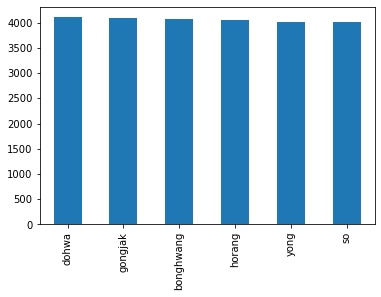

In [7]:
train_df['category'].value_counts().plot.bar()

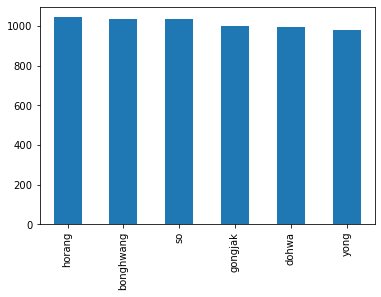

In [8]:
validate_df['category'].value_counts().plot.bar()

In [9]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]


In [10]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

In [11]:
train_generator=train_datagen.flow_from_dataframe(train_df,
                                 'images/img_mining/2eyes/augmented',
                                 x_col='filename',
                                 y_col='category',
                                  target_size=IMAGE_SIZE,
                                  class_mode='categorical',
                                  batch_size=batch_size
                                 )

Found 24357 validated image filenames belonging to 6 classes.


In [12]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                              "images/img_mining/2eyes/augmented",
                                                              x_col='filename',
                                                              y_col='category',
                                                              target_size=IMAGE_SIZE,
                                                              class_mode='categorical',
                                                              batch_size=batch_size)

Found 6090 validated image filenames belonging to 6 classes.


In [13]:
from keras.models import Sequential
from keras.layers import *

In [27]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 78, 22, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 78, 22, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 11, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 11, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 9, 64)         18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 37, 9, 64)         256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 4, 64)        

In [28]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [29]:
earlystop = EarlyStopping(patience=10),
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=2,
                                           verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [30]:
history = model.fit_generator(train_generator,
                              epochs=40,
                              validation_data=validation_generator,
                              validation_steps=total_validate//batch_size,
                              steps_per_epoch=total_train//batch_size,
                              callbacks=[earlystop,learning_rate_reduction])

Epoch 1/40
2435/2435 [==============================] - 62s 25ms/step - loss: 1.9193 - acc: 0.2685 - val_loss: 1.7140 - val_acc: 0.2911
Epoch 2/40
2435/2435 [==============================] - 59s 24ms/step - loss: 1.5923 - acc: 0.3394 - val_loss: 1.4419 - val_acc: 0.4103
Epoch 3/40
2435/2435 [==============================] - 59s 24ms/step - loss: 1.5111 - acc: 0.3729 - val_loss: 1.3242 - val_acc: 0.4529
Epoch 4/40
2435/2435 [==============================] - 59s 24ms/step - loss: 1.4598 - acc: 0.3968 - val_loss: 1.1408 - val_acc: 0.5278
Epoch 5/40
2435/2435 [==============================] - 59s 24ms/step - loss: 1.3813 - acc: 0.4310 - val_loss: 1.6700 - val_acc: 0.3131
Epoch 6/40
2434/2435 [============================>.] - ETA: 0s - loss: 1.3422 - acc: 0.4462
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2435/2435 [==============================] - 60s 25ms/step - loss: 1.3422 - acc: 0.4461 - val_loss: 1.1209 - val_acc: 0.5122
Epoch 7/40
2435/2435 [

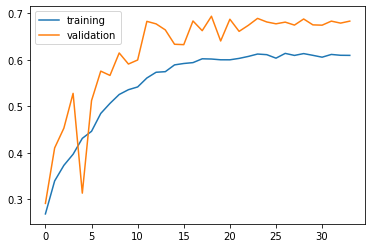

In [31]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [32]:
model.evaluate(train_generator)

2436/2436 [==============================] - 32s 13ms/step - loss: 0.6793 - acc: 0.6984


[0.6793234348297119, 0.6984029412269592]

In [33]:
model.save("model_2eyes_80_24.h5")

In [ ]:
loaded_model = load_model('model_2eyes.h5')
loaded_model.evaluate(train_generator)

### pretrained model을 통한 예측

In [117]:
categories=[]
train_dir=os.listdir("faces")
for filename in train_dir:
    category=filename.split('_')[0]
    if category == 'bonghwang':
        categories.append('bonghwang')
    if category == 'dohwa':
        categories.append('dohwa')
    if category == 'gongjak':
        categories.append('gongjak')
    if category == 'horang':
        categories.append('horang')
    if category == 'so':
        categories.append('so')
    if category == 'yong':
        categories.append('yong')

In [118]:
categories

['bonghwang',
 'bonghwang',
 'bonghwang',
 'bonghwang',
 'bonghwang',
 'bonghwang',
 'gongjak',
 'gongjak',
 'gongjak',
 'gongjak']

In [119]:
df=pd.DataFrame({'filename':train_dir,'category':categories})
df

,filename,category
0,bonghwang_1.jpg,bonghwang
1,bonghwang_2.jpg,bonghwang
2,bonghwang_3.jpg,bonghwang
3,bonghwang_4.jpg,bonghwang
4,bonghwang_5.jpg,bonghwang
5,bonghwang_6.jpg,bonghwang
6,gongjak_1.jpg,gongjak
7,gongjak_2.jpg,gongjak
8,gongjak_3.jpg,gongjak
9,gongjak_4.jpg,gongjak


In [120]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(df,
                                 'faces/',
                                 x_col='filename',
                                 y_col='category',
                                  target_size=IMAGE_SIZE,
                                  class_mode='categorical',
                                  batch_size=batch_size)

Found 10 validated image filenames belonging to 2 classes.


In [121]:
output = loaded_model.predict_generator(validation_generator,steps = 1)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(validation_generator.class_indices)
print(output)

{'bonghwang': 0, 'gongjak': 1}
[[0.067 0.022 0.820 0.000 0.089 0.003]
 [0.995 0.003 0.000 0.000 0.001 0.001]
 [0.000 0.000 0.010 0.000 0.000 0.989]
 [0.067 0.022 0.820 0.000 0.089 0.003]
 [0.440 0.296 0.085 0.000 0.179 0.000]
 [0.287 0.099 0.424 0.014 0.174 0.002]
 [0.989 0.001 0.009 0.000 0.001 0.000]
 [0.966 0.018 0.002 0.000 0.005 0.008]
 [0.000 0.000 0.008 0.000 0.000 0.992]
 [0.440 0.296 0.085 0.000 0.179 0.000]]


In [122]:
test=[]
print(len(output))
for i in output:
    test.append(i.argmax())

10


In [123]:
test

[2, 0, 5, 2, 0, 2, 0, 0, 5, 0]

In [136]:
dap = [0,0,0,0,0,0,1,1,1,1]

In [137]:
acc = []
for i in range(10):
    if test[i] == dap[i]:
        acc.append(1)
    else:
        acc.append(0)

In [138]:
acc

[0, 1, 0, 0, 1, 0, 0, 0, 0, 0]

NameError: name 'ᄆᄎᄎ' is not defined